In [2]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

In [3]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2

features = torch.randn(num_examples, 
                       num_inputs, 
                       dtype=torch.float32
                      )

labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b

labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), 
                       dtype=torch.float32
                      )

In [4]:
features

tensor([[ 0.0117, -0.2411],
        [-1.4095,  0.8059],
        [ 0.5070,  0.9303],
        ...,
        [ 0.2410, -1.4282],
        [-0.5789, -0.3795],
        [-1.4533, -0.5986]])

In [7]:
print(labels.size())

print(features.size())

torch.Size([1000])
torch.Size([1000, 2])


In [8]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

    
def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

/tmp/ipykernel_1893/3397691412.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


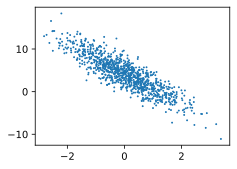

In [9]:
set_figsize()


plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

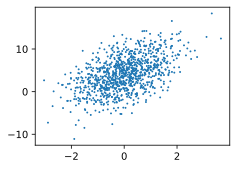

In [10]:
plt.scatter(features[:, 0].numpy(), labels.numpy(), 1);

## 3.2.2 读取数据

在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本。这里我们定义一个函数：它每次返回`batch_size`（批量大小）个随机样本的特征和标签。

In [11]:
# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的

    for i in range(0, num_examples, batch_size):
        # 最后一次可能不足一个batch
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) 
        yield features.index_select(0, j), labels.index_select(0, j)


In [33]:
num_examples = len(features)
indices = list(range(num_examples))
random.shuffle(indices)  # 样本的读取顺序是随机的


tt = torch.LongTensor(indices[2: min(2 + batch_size, num_examples)]) 

tt

tensor([ 11, 642, 473,   8, 972,  21, 172, 191, 999, 595])

In [40]:
train_data = features.index_select(0, tt)
train_labels = labels.index_select(0, tt)

train_data

tensor([[-0.4101,  0.5602],
        [-1.1936, -0.0406],
        [-0.2739,  0.5860],
        [ 1.8074,  0.9342],
        [ 1.1040, -0.5509],
        [ 0.1592, -1.5889],
        [-1.0545, -0.2032],
        [ 0.2092,  0.2232],
        [-1.4533, -0.5986],
        [ 0.1112, -0.2125]])

In [41]:
train_labels

tensor([1.4760, 1.9457, 1.6545, 4.6293, 8.2784, 9.9254, 2.7902, 3.8522, 3.3339,
        5.1378])

让我们读取第一个小批量数据样本并打印。每个批量的特征形状为(10, 2)，分别对应批量大小和输入个数；标签形状为批量大小。

In [12]:
batch_size = 10


for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[-0.9089, -0.7856],
        [-1.4495,  0.0856],
        [-0.7724,  1.1464],
        [-0.1877, -1.0794],
        [-1.7383, -1.0715],
        [ 0.4566,  0.6329],
        [ 0.6669, -0.0947],
        [ 0.6769,  0.0034],
        [ 1.1605,  0.0533],
        [ 0.6989, -0.8092]]) tensor([ 5.0458,  0.9965, -1.2376,  7.4947,  4.3614,  2.9624,  5.8645,  5.5491,
         6.3497,  8.3506])


## 3.2.3 初始化模型参数

我们将权重初始化成均值为0、标准差为0.01的正态随机数，偏差则初始化成0。

In [13]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), 
                 dtype=torch.float32
                )

b = torch.zeros(1, dtype=torch.float32)

In [14]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0.], requires_grad=True)

## 3.2.4 定义模型

下面是线性回归的矢量计算表达式的实现。我们使用`mm`函数做矩阵乘法。

In [15]:
def linreg(X, w, b):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    return torch.mm(X, w) + b

## 3.2.5 定义损失函数

我们使用上一节描述的平方损失来定义线性回归的损失函数。在实现中，我们需要把真实值`y`变形成预测值`y_hat`的形状。以下函数返回的结果也将和`y_hat`的形状相同。

In [16]:
def squared_loss(y_hat, y):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    # 注意这里返回的是向量, 另外, pytorch里的MSELoss并没有除以 2
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

## 3.2.6 定义优化算法

以下的`sgd`函数实现了上一节中介绍的小批量随机梯度下降算法。它通过不断迭代模型参数来优化损失函数。这里自动求梯度模块计算得来的梯度是一个批量样本的梯度和。我们将它除以批量大小来得到平均值。

In [17]:
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data

## 3.2.7 训练模型

在训练中，我们将多次迭代模型参数。在每次迭代中，我们根据当前读取的小批量数据样本（特征`X`和标签`y`），通过调用反向函数`backward`计算小批量随机梯度，并调用优化算法`sgd`迭代模型参数。由于我们之前设批量大小`batch_size`为10，每个小批量的损失`l`的形状为(10, 1)。回忆一下自动求梯度一节。由于变量`l`并不是一个标量，所以我们可以调用`.sum()`将其求和得到一个标量，再运行`l.backward()`得到该变量有关模型参数的梯度。注意在每次更新完参数后不要忘了将参数的梯度清零。

在一个迭代周期（epoch）中，我们将完整遍历一遍`data_iter`函数，并对训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。这里的迭代周期个数`num_epochs`和学习率`lr`都是超参数，分别设3和0.03。在实践中，大多超参数都需要通过反复试错来不断调节。虽然迭代周期数设得越大模型可能越有效，但是训练时间可能过长。而有关学习率对模型的影响，我们会在后面“优化算法”一章中详细介绍。

In [18]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数
        
        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
        pass
    
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.037625
epoch 2, loss 0.000134
epoch 3, loss 0.000050


训练完成后，我们可以比较学到的参数和用来生成训练集的真实参数。它们应该很接近。

In [19]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 2.0001],
        [-3.3988]], requires_grad=True)
4.2 
 tensor([4.1999], requires_grad=True)
